## Path Finding in the City of Austin

This notebook demonstrates pathfinding along the city of Austin street network using Xarray-spatial's `pathfinding` module.
The a_star_search function provides the shortest path between any two points.

#### Setup:

First, we'll need to import some packages: these include the basic array manipulation ones,  
as well as some geospatial-focused ones.
We'll also grab a few datashader functions for easy rendering.

In [1]:
import datashader as ds
from datashader.transfer_functions import shade, stack, dynspread, set_background
import geopandas
import numpy as np
import pandas as pd
import spatialpandas
import xarray as xa

from xrspatial import a_star_search

### Load data

Now, we're ready to load up the data and transform it into a format we can work with.

To download the examples data, run the command `xrspatial examples` in your terminal. All the data will be stored in your current directory inside a folder named `xrspatial-examples`.

We'll start by opening the shapefile, transforming the crs (coordinate reference system) to the commonly-used longitude/latitude,  
and, after a quick clean-up, transforming it to a spatialpandas GeoDataFrame.

Now our data is ready to be aggregated to an xarray DataArray raster.

In [2]:
streets = geopandas.read_file(
    "./xrspatial-examples/data/geo_export_9c395dda-0b29-41ec-89b4-a51a898f7104.shp"
)
streets = streets.to_crs("EPSG:4326")
streets = streets.explode("geometry").reset_index(drop=True)
streets_spd = spatialpandas.GeoDataFrame(streets, geometry="geometry")

### Define study area (find range of x and y) and aggregate:

To finish off our set-up:
- We'll define a study area, with xmin, xmax, ymin, and ymax; this set the x, y coordinates we'll be using in our aggregate.
- We'll set up a datashader Canvas object, which provides an easy frame for setting up a new raster and aggregating data to it.
- Finally, we'll aggregate the streets data into a lines raster with Canvas.line.

- We also set up the start and goal point (x, y) coordinates, and set up a DataFrame and aggregation for visualization.

Some shading and stacking of all of this displays our complete setup below.

In [3]:
xmin, ymin, xmax, ymax = (
    streets.geometry.bounds.minx.min(),
    streets.geometry.bounds.miny.min(),
    streets.geometry.bounds.maxx.max(),
    streets.geometry.bounds.maxy.max(),
)
xrange = (xmin, xmax)
yrange = (ymin, ymax)
xrange, yrange

((-98.170507844129, -97.36979731249), (29.995950090365, 30.654731756587))

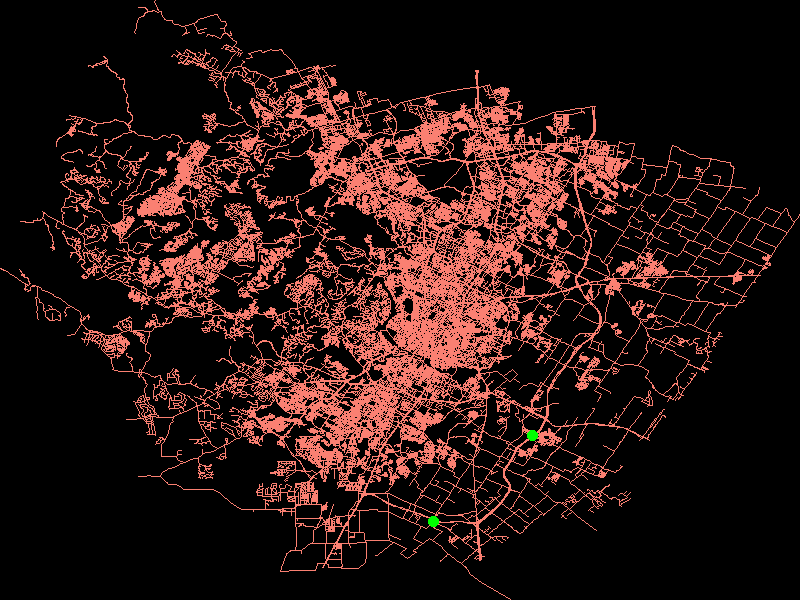

In [4]:
H, W = 600, 800
cvs = ds.Canvas(plot_width=W, plot_height=H, x_range=xrange, y_range=yrange)

street_agg = cvs.line(streets_spd, geometry="geometry")
street_shaded = dynspread(shade(street_agg, cmap=["salmon"]))

# Pick two locations
start = (-97.73662282, 30.08214069)
goal = (-97.63753489650679, 30.1765660638542)

location_df = pd.DataFrame({"x": [start[0], goal[0]], "y": [start[1], goal[1]]})
location_agg = cvs.points(location_df, "x", "y")
location_shaded = dynspread(shade(location_agg, cmap=["lime"]), threshold=1, max_px=5)

set_background(stack(street_shaded, location_shaded), "black")

### Shortest path using A* from start location to goal location

Now, we can do some pathfinding:

In `a_star_search`, we'll input the Austin city streets lines aggregate we built above, the start and goal point coordinates, and barriers:
    - Barriers defines all non-crossable points in the raster: for our streets raster, this includes all non-street areas, all of which have 0 set as their value. 

We've also set `snap-start` and `snap-goal` to `True`: this helps ensure the start and goal points are set correctly.

The result is a the shortest path al
    

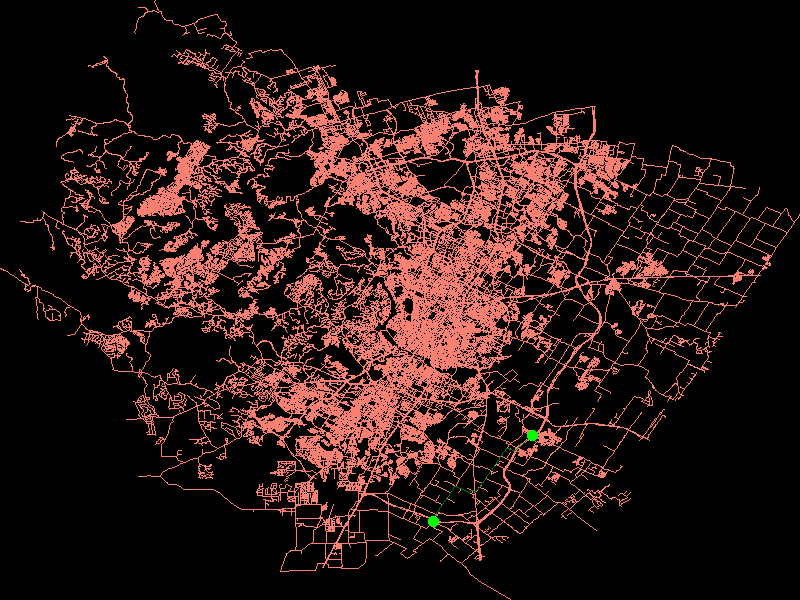

In [5]:
# find the path from start to goal,
# barriers are uncrossable cells. In this case, they are cells with a value of 0

path_agg = a_star_search(
    street_agg, start, goal, barriers=[0], snap_start=True, snap_goal=True
)

path_shaded = dynspread(shade(path_agg, cmap=["green"]))
set_background(stack(street_shaded, path_shaded, location_shaded), "black")